Importando as Bibliotecas

In [2]:
import qiskit_nature
from qiskit_algorithms.optimizers import *
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q import *
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
from qiskit_nature.exceptions import QiskitNatureError
import matplotlib.pyplot as plt
import numpy as np
import time

Vamos criar algumas funções para facilitação.

In [3]:

def GS_classic(d, base = "sto3g") :

    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {d}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    problem = driver.run()
    result = solver.solve(problem)

    return result.groundenergy + result.nuclear_repulsion_energy

In [4]:
intervalo = np.concatenate((np.linspace(0.3,2.5,15), np.linspace(2.5,10,5)))


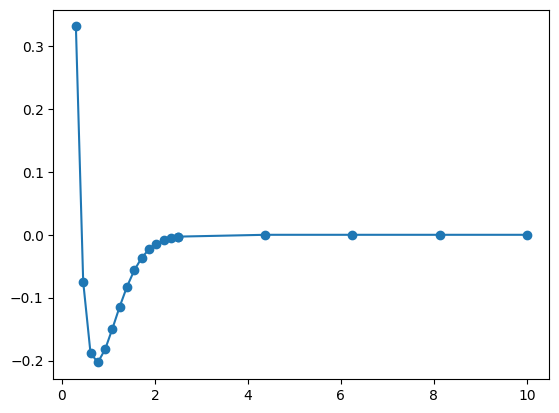

In [5]:
gs = [GS_classic(a) - GS_classic(20) for a in intervalo]
plt.plot(intervalo, gs, '-o')

Agora vamos focar em aplicar POO e usar outros sistemas como a solução por VQE

In [6]:
def GS_VQE(a, base = 'sto3g', mapper = JordanWignerMapper(), otimizador = COBYLA()):
    #Usando Jordan Wigner, vou tentar outros.

    #procedimento padrão
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()

    #Relevante testar outros tipos de Ansatz e o uso de hartreefock
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        reps=1,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
    
    #SLSQP é o otimizadoer ? Testar outros, cobyla ? 
    #Pode ser qualquer otimizador mas precisamos ter cuidado pois 
    #alguns não lidam bem com o fato dos qubits not being noiseledd in real hardware
    vqe_solver = VQE(Estimator(), ansatz, otimizador)
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem) 
    
    return res.groundenergy + res.nuclear_repulsion_energy 

vamos criar uma lista de otimizadores.

In [7]:
otimizadores = [SLSQP(), COBYLA(), SPSA(), NELDER_MEAD(), AQGD(), P_BFGS()]
#QNSPSA()

In [8]:
inf = GS_VQE(10, otimizador = SLSQP())
inf2 = GS_VQE(20,otimizador = SLSQP())
inter = np.arange(0.3,30,0.5)
teste = [GS_VQE(a, otimizador = SLSQP()) for a in inter]

In [9]:
print(inf)
print(inf2)
print(GS_VQE(30, otimizador = SLSQP()))

-0.9331636979989543
-0.18501661574065373
-0.17619699555865395


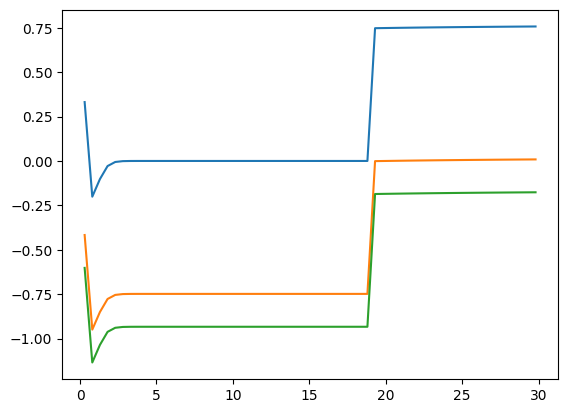

In [10]:
plt.plot(inter, teste - inf)
plt.plot(inter, teste - inf2)
plt.plot(inter, teste)

In [11]:
energia_by_otimizador = []
tempos = []
for i in otimizadores:
    ti = time.time()
    inf = GS_VQE(10, otimizador = i)
    aux = [GS_VQE(a, otimizador=i) - inf for a in intervalo]
    tf = time.time()
    tempos.append(tf-ti)
    energia_by_otimizador.append(aux)


In [12]:
print(tempos)

[12.061525344848633, 82.88101410865784, 122.18716764450073, 102.97314953804016, 8.290867328643799, 55.7557258605957]


In [13]:
labels = ['SLSQP', 'COBYLA', 'SPSA', 'NELDER_MEAD', 'AQGD', 'F_BFGS']

In [14]:
np.array(energia_by_otimizador[1]) - np.array(energia_by_otimizador[3])

array([ 4.38393655e-09,  8.47423354e-09,  1.98608714e-08,  1.85635418e-09,
        8.36895953e-09,  4.60777216e-09,  1.56276969e-08,  6.33804320e-09,
       -7.16462445e-11,  1.10129861e-09,  3.01938050e-08,  1.01090534e-07,
        6.81824170e-08,  3.89991162e-07,  7.60951952e-07,  7.60951952e-07,
       -7.92796817e-08,  5.27222332e-09,  8.84338403e-09,  0.00000000e+00])

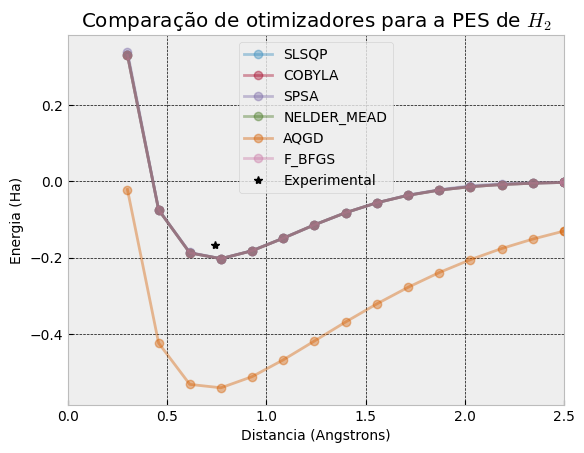

In [34]:
for i in range(len(tempos)):
    plt.plot(intervalo, np.array(energia_by_otimizador[i]), '-o', alpha=0.4, label = labels[i])
plt.plot(0.74, -4.52*0.0367493, '*', color = 'black', label = 'Experimental')

plt.legend()
plt.title('Comparação de otimizadores para a PES de $H_2$')
plt.xlabel('Distancia (Angstrons)')
plt.ylabel('Energia (Ha)')
plt.style.use('bmh')
plt.grid(color='black')
plt.xlim(0,2.5)
plt.show()
    

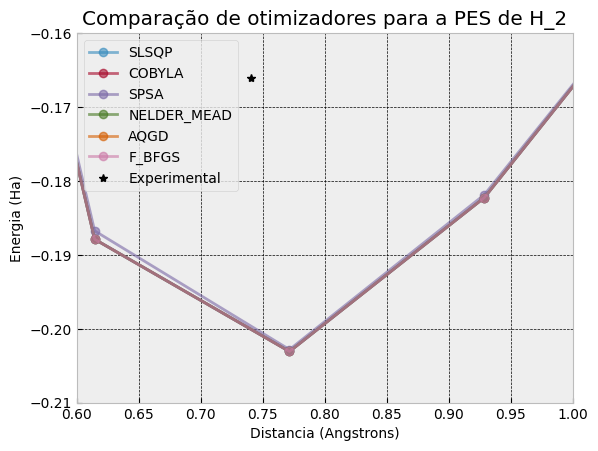

In [35]:
for i in range(len(tempos)):
    plt.plot(intervalo, np.array(energia_by_otimizador[i]), '-o', alpha=0.6, label = labels[i])
plt.plot(0.74, -4.52*0.0367493, '*', color = 'black', label = 'Experimental')

plt.xlim(0.6,1)
plt.ylim(-0.21,-0.16)
plt.legend()
plt.title('Comparação de otimizadores para a PES de H_2')
plt.xlabel('Distancia (Angstrons)')
plt.ylabel('Energia (Ha)')
plt.style.use('bmh')
plt.grid(color='black')
plt.show()
    